In [1]:
#1st step - Install all required libraries
"""
!pip install --upgrade pandas
!pip install --upgrade numpy
!pip install --upgrade matplotlib
!pip install --upgrade sklearn
!pip install --upgrade seaborn
!pip install --upgrade scipy
!pip install --upgrade tensorflow
!pip install --upgrade keras
!pip install --upgrade sklearn
"""

'\n!pip install --upgrade pandas\n!pip install --upgrade numpy\n!pip install --upgrade matplotlib\n!pip install --upgrade sklearn\n!pip install --upgrade seaborn\n!pip install --upgrade scipy\n!pip install --upgrade tensorflow\n!pip install --upgrade keras\n!pip install --upgrade sklearn\n'

In [1]:
import scipy.signal as sci
import scipy.stats as scp
import pandas as pd
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from math import sqrt
import math
import os
import json
import time
import seaborn as sns
from core.data_processor import DataLoader
from core.model import Model
import datetime

Using TensorFlow backend.


In [2]:
#Parameters 
class Parameters(object):
    pass

param = Parameters()
param.tickSize = 0.5 #tick size is 0.5 GBp i.e. 0.005 GBP

param.fileDirectory = './intraday/'
param.trade_InSampleFile = 'trade_in.csv'
param.quote_InSampleFile = 'quote_in.csv'

param.trade_OutSampleFile = 'trade_out.csv'
param.quote_OutSampleFile = 'quote_out.csv'

In [3]:
param.fileDirectory

'./intraday/'

In [4]:
#Identify future mid prices - 30 seconds duration
def IdentifyFutureMidPrices(df, predictionDuration = '30S'):
    futureData = df.resample(predictionDuration, on = 'datetime').first()
    futureData = futureData.shift(periods=-1)
    futureData.drop(columns = ['datetime', 'sym', 'bsize', 'bid', 'ask', 'asize'], inplace = True)
    futureData.rename(columns = {"mid":"futMid"}, inplace = True)
    futureData.reset_index(inplace = True)
    return pd.merge_asof(df, futureData[['datetime', 'futMid']], on='datetime')

def ReadCSV(file):
    print('Loading file - ' + file)
    df = pd.read_csv(file)
    df['datetime'] = pd.to_datetime(df['datetime'], format="%Y-%m-%dD%H:%M:%S.%f")
    return df

#Load data
def LoadData(path, tradeFile, quoteFile):
    tradeFile = os.path.join(path, tradeFile)
    quoteFile = os.path.join(path, quoteFile)

    trade_df = ReadCSV(tradeFile)
    quote_df = ReadCSV(quoteFile)
    
    quote_df['mid'] = 0.5*(quote_df['bid'].copy() + quote_df['ask'].copy())
    quote_df['midChangeGroup'] = quote_df['mid'].diff().ne(0).cumsum()
    quote_df = IdentifyFutureMidPrices(quote_df)
    return trade_df, quote_df

#Evaluation function
#df should contain columns - datetime, sym, bsize, bid, ask, asize, predMid (model predicted mid-price)
#Function to evaluate results
def RMS(df):
    df = df.groupby(['midChangeGroup']).first().reset_index()
    tmp = df.dropna(subset=['predMid', 'futMid'])
    rms = sqrt(mean_squared_error(tmp['futMid'], tmp['predMid']))
    predCount = len(tmp['predMid'])
    print('RMS = %.4f. #Predictions = %s' % (rms, predCount))

In [5]:
df_tradein,df_quotein   = LoadData(param.fileDirectory,param.trade_InSampleFile,param.quote_InSampleFile)
df_tradeout,df_quoteout = LoadData(param.fileDirectory,param.trade_OutSampleFile,param.quote_OutSampleFile)

Loading file - ./intraday/trade_in.csv
Loading file - ./intraday/quote_in.csv
Loading file - ./intraday/trade_out.csv
Loading file - ./intraday/quote_out.csv


In [6]:
df_quotein.head()

,datetime,sym,bsize,bid,ask,asize,mid,midChangeGroup,futMid
0,2018-02-01 05:00:09.686,TEST.L,11850,4800.0,5100.0,8450,4950.0,1,NaN
1,2018-02-01 07:50:00.048,TEST.L,11850,4800.0,4884.0,237,4842.0,2,NaN
2,2018-02-01 07:50:00.077,TEST.L,11965,4800.0,4884.0,237,4842.0,2,NaN
3,2018-02-01 07:50:00.078,TEST.L,12084,4800.0,4884.0,237,4842.0,2,NaN
4,2018-02-01 07:50:00.095,TEST.L,12384,4800.0,4884.0,237,4842.0,2,NaN


In [7]:
df_tradein.head()

,datetime,sym,price,size
0,2018-02-01 07:50:00.077,TEST.L,4884.0,115
1,2018-02-01 07:50:00.078,TEST.L,4884.0,234
2,2018-02-01 07:50:00.095,TEST.L,4884.0,534
3,2018-02-01 07:50:00.177,TEST.L,4884.0,534
4,2018-02-01 07:50:00.179,TEST.L,4884.0,534


In [8]:
#Feature Engineering  
def feature_engg(df_quote,df_trade):
    df1 = df_quote[['datetime', 'bid', 'ask', 'bsize', 'asize','midChangeGroup','futMid','mid']]
    df2 = df_trade[['datetime', 'price', 'size']]

    #Adding arrival rate column
    df2 = df2.assign(arrival_rate = (df2['datetime']-df2['datetime'].shift(1)).dt.total_seconds())
    df2['arrival_rate'].replace(to_replace=0, method='ffill', inplace = True)

    #To find when the market opens 
    trade_rate = df2['size'].shift(-1)-df2['size']
    peaks = sci.find_peaks(x=-trade_rate, threshold=10000)[0]
    start = peaks[0]+1
    start_bid = x = df1.loc[df1['datetime']==df2.loc[start,'datetime'], 'bid'].reset_index(drop = True)[0]


    trade = df2[start:len(df2)]
    quote = df1[df1['datetime']>=df2.loc[start,'datetime']]

    #Merging trade and quote files
    df = pd.merge_asof(quote, trade, direction='backward', by='datetime')
    df.reset_index(inplace = True, drop = True)


    df['Trade'] = 1
    df.loc[df['arrival_rate'].isna(), 'Trade'] = 0
    df['Buy'] = np.nan
    df.loc[df['price'] == df['ask'].shift(1), 'Buy'] = 1
    df.loc[df['price'] == df['bid'].shift(1), 'Buy'] = 0
    if df.loc[0, 'price'] == start_bid:
        df.loc[0, 'Buy'] = 0
    else:
        df.loc[0, 'Buy'] = 1

    df['spread'] = df['ask'] - df['bid']
    return df


In [9]:
df = feature_engg(df_quotein,df_tradein)

In [10]:
df.head()

,datetime,bid,ask,bsize,asize,midChangeGroup,futMid,mid,price,size,arrival_rate,Trade,Buy,spread
0,2018-02-01 08:00:18.246,4828.5,4836.0,212,160,6,4845.25,4832.25,4836.0,140.0,2.207,1,1.0,7.5
1,2018-02-01 08:00:18.246,4828.5,4836.0,212,20,6,4845.25,4832.25,4836.0,140.0,2.207,1,1.0,7.5
2,2018-02-01 08:00:18.248,4828.5,4837.0,212,936,7,4845.25,4832.75,NaN,NaN,NaN,0,NaN,8.5
3,2018-02-01 08:00:18.248,4832.0,4837.0,31,936,8,4845.25,4834.50,NaN,NaN,NaN,0,NaN,5.0
4,2018-02-01 08:00:18.248,4832.0,4837.0,62,936,8,4845.25,4834.50,NaN,NaN,NaN,0,NaN,5.0


In [11]:
#Normalizing the feature vectors
def norm_zero(df,column):    
    A = df[column].copy()
    B = df[column].copy()
    A = A.dropna()
    mean = A.mean()
    std = A.std()
    B = (B - df['Trade']*mean)/std
    return B
df_std = df.copy()    
df_std['price']= norm_zero(df,'price')
df_std['size']= norm_zero(df,'size')

temp = df[['bid', 'ask', 'bsize', 'asize','mid','spread']].copy()

def boxcox(X):
    "Returns boxcox of multidimension arrays"
    for cols in X.columns:
        A=scp.boxcox(X[cols], lmbda=None, alpha=None)
        X[cols] = A[0]
    return X   

# temp = boxcox(temp)
df_std[['bid', 'ask', 'bsize', 'asize','mid','spread']] = (temp-temp.mean())/temp.std()

mean = df['mid'].mean()
std = df['mid'].std()
df_std = df_std.drop('midChangeGroup',axis=1)
df_std = df_std.drop('futMid',axis=1)
df_std=df_std.fillna(0)
df_std.Buy = df_std.Buy.astype('int64')
df_std.info()
#To save
# df_std.to_csv('merged.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1672756 entries, 0 to 1672755
Data columns (total 12 columns):
datetime        1672756 non-null datetime64[ns]
bid             1672756 non-null float64
ask             1672756 non-null float64
bsize           1672756 non-null float64
asize           1672756 non-null float64
mid             1672756 non-null float64
price           1672756 non-null float64
size            1672756 non-null float64
arrival_rate    1672756 non-null float64
Trade           1672756 non-null int64
Buy             1672756 non-null int64
spread          1672756 non-null float64
dtypes: datetime64[ns](1), float64(9), int64(2)
memory usage: 153.1 MB


<IPython.core.display.Javascript object>


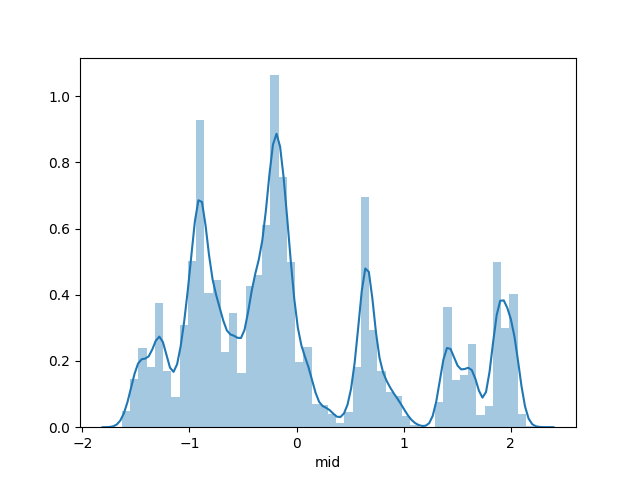

In [13]:
sns.distplot(df_std.mid)
plt.show()

In [12]:
df_std.head()

,datetime,bid,ask,bsize,asize,mid,price,size,arrival_rate,Trade,Buy,spread
0,2018-02-01 08:00:18.246,1.935709,1.986011,-0.353249,-0.602629,1.960928,2.01923,-0.004412,2.207,1,1,3.005108
1,2018-02-01 08:00:18.246,1.935709,1.986011,-0.353249,-0.935377,1.960928,2.01923,-0.004412,2.207,1,1,3.005108
2,2018-02-01 08:00:18.248,1.935709,1.993925,-0.353249,1.241749,1.964886,0.00000,0.000000,0.000,0,0,3.477803
3,2018-02-01 08:00:18.248,1.963408,1.993925,-0.651848,1.241749,1.978736,0.00000,0.000000,0.000,0,0,1.823369
4,2018-02-01 08:00:18.248,1.963408,1.993925,-0.600707,1.241749,1.978736,0.00000,0.000000,0.000,0,0,1.823369


In [14]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()

In [15]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
        # Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

In [6]:
# LSTM model in ./core/model.py
# config contains all required parameters for the model 

def model_run():
    configs = json.load(open('config.json', 'r'))
    if not os.path.exists(configs['model']['save_dir']): os.makedirs(configs['model']['save_dir'])

    data = DataLoader(
        configs['data']['filename'],
        configs['data']['train_test_split'],
        configs['data']['columns']
    )

    model = Model()
    model.build_model(configs)
    x, y = data.get_train_data(
        seq_len=configs['data']['sequence_length'],
        normalise=configs['data']['normalise']
    )

    '''
        # in-memory training
        model.train(
            x,
            y,
            epochs = configs['training']['epochs'],
            batch_size = configs['training']['batch_size'],
            save_dir = configs['model']['save_dir']
        )
    '''
    # out-of memory generative training
    steps_per_epoch = math.ceil((data.len_train - configs['data']['sequence_length']) / configs['training']['batch_size'])
    model.train_generator(
        data_gen=data.generate_train_batch(
            seq_len=configs['data']['sequence_length'],
            batch_size=configs['training']['batch_size'],
            normalise=configs['data']['normalise']
        ),
        epochs=configs['training']['epochs'],
        batch_size=configs['training']['batch_size'],
        steps_per_epoch=steps_per_epoch,
        save_dir=configs['model']['save_dir']
    )

    x_test, y_test = data.get_test_data(
        seq_len=configs['data']['sequence_length'],
        normalise=configs['data']['normalise']
    )
# model_run()

[Model] Model Compiled
Time taken: 0:00:01.953746
[Model] Training Started
[Model] 100 epochs, 256 batch size, 5227.0 batches per epoch
Epoch 1/100
5227/5227 [==============================] - 14484s 3s/step - loss: 0.0072
Epoch 2/100
5227/5227 [==============================] - 14367s 3s/step - loss: 0.0061
Epoch 3/100
2037/5227 [==========>...................] - ETA: 3:26:58 - loss: 0.0228

KeyboardInterrupt: 

In [12]:
#Loading saved model
from keras.models import load_model

# returns a compiled model
# identical to the previous one
#To run if not trained the model
configs = json.load(open('config.json', 'r'))
model = Model()
model.build_model(configs)
model.load_model('./model.h5')


[Model] Model Compiled
Time taken: 0:00:01.778387
[Model] Loading model from file ./model.h5


In [14]:
#Please fix the error 
# #Getting the test data for testing
# df_test = feature_engg(df_quoteout,df_tradeout)
# df_std_test = df_test.copy()    

# def norm_zero_test(df_test,df,column):    
#     A = df[column].copy()
#     B = df_test[column].copy()
#     A = A.dropna()
#     mean = A.mean()
#     std = A.std()
#     B = (B - df_test['Trade']*mean)/std
#     return B
   
# df_std_test['price']= norm_zero_test(df_test,df,'price')
# df_std_test['size']= norm_zero_test(df_test,df,'size')

# temp = df[['bid', 'ask', 'bsize', 'asize','mid','spread']].copy()
# temp_test = df_test[['bid', 'ask', 'bsize', 'asize','mid','spread']].copy()

# df_std_test[['bid', 'ask', 'bsize', 'asize','mid','spread']] = (temp_test-temp.mean())/temp.std()
# df_std_test=df_std_test.fillna(0)
# df_std_test.Buy = df_std_test.Buy.astype('int64')
# df_std.to_csv('merged_test.csv')


In [13]:
#For testing the data, we are testing it on cross validation data
data_test = DataLoader(configs['data']['filename'],0.9848,configs['data']['columns'])
x_test, y_test = data_test.get_test_data(seq_len=configs['data']['sequence_length'],normalise=configs['data']['normalise'])


In [14]:
A = model.predict_at_new_mid_one(x_test,configs['data']['sequence_length'],20,3)


[Model] Predicting at new mid price...
Done


In [38]:
len(A[0])

222

In [15]:
A=model.predict_point_by_point(x_test[:1])

[Model] Predicting Point-by-Point...


In [29]:
A = model.predict_sequences_multiple(x_test,50,10)

[Model] Predicting Sequences Multiple...


In [48]:
A[47]

array([-1.38029814, -1.3814192 ,  0.77186205, -0.02031871, -0.06741215,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -1.38090706])

In [41]:
x_test[3]

array([[-1.38029814e+00, -1.38141920e+00, -9.91913759e-02,
        -4.40864538e-02, -6.74121547e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.38090706e+00],
       [-1.38029814e+00, -1.38141920e+00,  1.62891915e-02,
        -4.40864538e-02, -6.74121547e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.38090706e+00],
       [-1.38029814e+00, -1.38141920e+00, -9.91913759e-02,
        -4.40864538e-02, -6.74121547e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.38090706e+00],
       [-1.38029814e+00, -1.38537623e+00, -9.91913759e-02,
        -8.45059545e-01, -3.03759852e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.38288565e+00],
       [-1.38029814e+00, -1.38537623e+00, -5.21520308e-01,
        -8.45059545e-01, -3.03759852e-01,  0.00000000e+00,
  

In [24]:
#To find the indicies where mid price changes
i_split = int(len(df_std) * 0.9848)
data_test  = df.iloc[i_split:]
data_test=data_test.reset_index(inplace=False,drop=True)
data_test

,datetime,bid,ask,bsize,asize,midChangeGroup,futMid,mid,price,size,arrival_rate,Trade,Buy,spread
0,2018-02-13 15:27:01.085,4409.5,4410.5,110,457,365484,4411.0,4410.00,NaN,NaN,NaN,0,NaN,1.0
1,2018-02-13 15:27:01.089,4409.5,4410.5,110,438,365484,4411.0,4410.00,NaN,NaN,NaN,0,NaN,1.0
2,2018-02-13 15:27:01.089,4409.5,4410.5,110,395,365484,4411.0,4410.00,NaN,NaN,NaN,0,NaN,1.0
3,2018-02-13 15:27:01.409,4409.5,4410.5,366,395,365484,4411.0,4410.00,NaN,NaN,NaN,0,NaN,1.0
4,2018-02-13 15:27:01.409,4409.5,4410.5,436,395,365484,4411.0,4410.00,NaN,NaN,NaN,0,NaN,1.0
5,2018-02-13 15:27:01.409,4409.5,4410.5,366,395,365484,4411.0,4410.00,NaN,NaN,NaN,0,NaN,1.0
6,2018-02-13 15:27:01.502,4409.5,4410.0,366,58,365485,4411.0,4409.75,NaN,NaN,NaN,0,NaN,0.5
7,2018-02-13 15:27:01.502,4409.5,4410.0,110,58,365485,4411.0,4409.75,NaN,NaN,NaN,0,NaN,0.5
8,2018-02-13 15:27:03.082,4409.5,4410.0,110,269,365485,4411.0,4409.75,NaN,NaN,NaN,0,NaN,0.5
9,2018-02-13 15:27:04.219,4409.5,4410.0,230,269,365485,4411.0,4409.75,NaN,NaN,NaN,0,NaN,0.5


In [25]:
# To get indices where mid price changes
indice_loc= data_test.midChangeGroup.drop_duplicates(keep='first', inplace=False).index
indice_loc = list(indice_loc)
indice_loc=[i for i in indice_loc if i<(indice_loc[-1]-990)]
len(indice_loc)



5014

In [97]:
#We have for 30 secs that is 200 time steps hence
# prediction = model.predict_at_new_mid(x_test, configs['data']['sequence_length'],200,indice_loc)


[Model] Predicting at new mid price...
Done


In [23]:
#Figure out timesteps of 30sec from that indice
def timestep(X,indice):
    start = X.loc[X['datetime'] <= X.loc[indice,'datetime']+datetime.timedelta(seconds = 30)].index[-1]
    timestep = start - indice
    return timestep
# timestep(data_test,1500)

In [51]:
#Prediction depending on 30 sec timestep
import time
start = time.time()
prediction = []
for i in indice_loc[:5]:
#     step = timestep(data_test,i)
    A = model.predict_at_new_mid_one(x_test,configs['data']['sequence_length'],20,i)
    temp = A[0][-1]
    prediction.append(temp)
end = time.time()
print(end-start)

[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
[Model] Predicting at new mid price...
Done
2.51862502098


In [42]:
A[0]

[-1.171555,
 -1.1714506,
 -1.1713936,
 -1.1713834,
 -1.1714057,
 -1.1705065,
 -1.1706744,
 -1.1706238,
 -1.1719433,
 -1.1717063,
 -1.1716858,
 -1.1716574,
 -1.1715688,
 -1.1715797,
 -1.1715138,
 -1.1702449,
 -1.1720169,
 -1.1717596,
 -1.1716503,
 -1.1716579]

In [52]:
prediction

[-1.17154, -1.1706787, -1.1715803, -1.172017, -1.1716579]

In [98]:
df = pd.DataFrame(prediction)


In [17]:
import time
start = time.time()
print(start)

1546866561.58


In [99]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-1.171487,-1.172016,-1.172196,-1.172244,-1.172164,-1.172019,-1.171868,-1.171732,-1.171620,-1.171536,...,-1.171241,-1.171241,-1.171241,-1.171241,-1.171241,-1.171241,-1.171241,-1.171241,-1.171241,-1.171241
1,-1.171218,-1.172192,-1.172396,-1.172400,-1.172277,-1.172096,-1.171922,-1.171771,-1.171650,-1.171561,...,-1.171241,-1.171241,-1.171241,-1.171241,-1.171241,-1.171241,-1.171241,-1.171241,-1.171241,-1.171241
2,-1.171782,-1.172196,-1.172328,-1.172373,-1.172258,-1.172084,-1.171908,-1.171756,-1.171635,-1.171545,...,-1.171241,-1.171241,-1.171241,-1.171241,-1.171241,-1.171241,-1.171241,-1.171241,-1.171241,-1.171241
3,-1.171620,-1.172243,-1.172274,-1.172277,-1.172163,-1.172006,-1.171852,-1.171717,-1.171610,-1.171529,...,-1.171241,-1.171241,-1.171241,-1.171241,-1.171241,-1.171241,-1.171241,-1.171241,-1.171241,-1.171241
4,-1.171555,-1.172037,-1.172180,-1.172242,-1.172160,-1.172017,-1.171869,-1.171735,-1.171625,-1.171542,...,-1.171241,-1.171241,-1.171241,-1.171241,-1.171241,-1.171241,-1.171241,-1.171241,-1.171241,-1.171241


In [102]:
#Making a new data frame containg fut mid and pred mid
A  = pd.DataFrame(predictions)
A = A*std+mean
# B = A.iloc[:,199]
Test = data_test.futMid.iloc[indice_loc].reset_index()
Test = pd.DataFrame(Test)
Test['Predmid'] = A


In [103]:
#RMS error
rms = sqrt(mean_squared_error(Test['futMid'], Test['Predmid']))
predCount = len(Test['Predmid'])
print('RMS = %.4f. #Predictions = %s' % (rms, predCount))

RMS = 34.7518. #Predictions = 5014
